In [44]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
from gurobipy import Model, GRB, quicksum
from Services.read_data import Dados
import math
import pandas as pd

In [46]:
# Inicialização da classe Dados
file_name = 'Dados\Modelo.xlsx'
dados = Dados(file_name)

In [47]:
# Definir conjuntos (como exemplo, defina os conjuntos de portos, tipos de contêineres, etc.)
P = dados.P  # Exemplo de 9 portos
K = dados.K   # Exemplo de 3 tipos de contêineres
C = dados.C   # Exemplo de 5 tipos de carga
T = dados.T  # Exemplo de 12 períodos de tempo

Qual a ordem? Queremos descobrir a ordem?

PNG, SSZ, SUA, PEC, MAO, MAO, PEC, SUA, SSZ, PNG

Isso são 10 portos, mas faria sentido desconsiderar um MAO do meio. Ficamos com rota de 9 portos?

ID Portos:

1: PEC; 2: PNG; 3: MAO; 4: SUA; 5: SSZ 

MAO aparece duas veze > subida e descida, mas não há fluxo

In [48]:
ordem = [2, 5, 4, 1, 3, 3, 1, 4, 5, 2]
ordem = pd.DataFrame(ordem, index=[i + 1 for i in range(len(ordem))], columns=['IdPorto'])

In [49]:
# Criar o modelo
model = Model("Modelo de Otimização de Cabotagem")

In [50]:
CT = model.addVar(vtype=GRB.CONTINUOUS, name="CT", lb=0, ub=1)  # Margem de contribuição
FF = model.addVars(P, P, K, C, T, vtype=GRB.CONTINUOUS, name="FF")  # Contêineres cheios embarcados
FE = model.addVars(P, P, K, T, vtype=GRB.CONTINUOUS, name="FE")    # Contêineres vazios embarcados
E = model.addVars(P, K, T, vtype=GRB.CONTINUOUS, name="E")         # Estoque de contêineres vazios
R = model.addVars(P, T, vtype=GRB.CONTINUOUS, name="R")            # Quantidade de TEU no navio
RSF = model.addVars(P, K, T, vtype=GRB.CONTINUOUS, name="RSF")     # Contêineres vazios retornando
RSE = model.addVars(P, K, T, vtype=GRB.CONTINUOUS, name="RSE")     # Contêineres vazios disponíveis
RLF = model.addVars(P, K, T, vtype=GRB.CONTINUOUS, name="RLF")     # Contêineres vazios liberados para exportação
RLE = model.addVars(P, K, T, vtype=GRB.CONTINUOUS, name="RLE")     # Contêineres vazios liberados para reposicionamento

RESTRIÇÕES

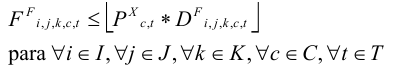

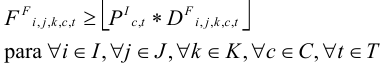

SF, SE, PI e PX são por ID de porto... Não por posição do porto na rota...

In [51]:
# Restrições de participação máxima e mínima do armador no tipo de carga
count_constr = 0
for i in dados.P:
    for j in dados.P:
        for k in dados.K:
            for c in dados.C:
                for t in dados.T:
                    # df_filtered = dados.DF[(dados.DF['I'] == i) & (dados.DF['J'] == j) & (dados.DF['K'] == k) & (dados.DF['C'] == c) & (dados.DF['T'] == t)]
                    df_filtered = dados.DF[ordem.loc[i].values[0], ordem.loc[j].values[0], k, c, t]
                    px_filtered = dados.PX[(dados.PX['I'] == ordem.loc[i].values[0]) & (dados.PX['C'] == c) & (dados.PX['T'] == t)]
                    pi_filtered = dados.PI[(dados.PI['I'] == ordem.loc[i].values[0]) & (dados.PI['C'] == c) & (dados.PI['T'] == t)]
                    if True:
                        count_constr += 1
                        df_value = df_filtered
                        px_value = px_filtered['PX'].values[0]
                        pi_value = pi_filtered['PX'].values[0]
                        model.addConstr(
                            FF[i, j, k, c, t] <= math.floor(df_value * px_value),
                            name=f"participacao_maxima_armador_{i}_{j}_{k}_{c}_{t}"
                        )
                        model.addConstr(
                            FF[i, j, k, c, t] >= math.floor(df_value * pi_value),
                            name=f"participacao_minima_armador_{i}_{j}_{k}_{c}_{t}"
                        )

print(f"Restrições de participação máxima e mínima do armador no tipo de carga: {count_constr} cada")

Restrições de participação máxima e mínima do armador no tipo de carga: 9600 cada


Alguns dados consideram os indices I, J como os IDs dos portos (de 1 a 5)

No caso das restrições, como FF, estamos considerando como índice de posição na rota (1 a 9)

Isso é o correto? (Acho que sim) Ou nas restrições, também devem ter índices de portos de 1 a 5?

Mesma dúvida para RSF, que considera SF(que utiliza índices de 1 a 5) e RSE

DF considerado zero para índices sem dados, todas as restrições de FF adicionadas (incluindo as que resultam em valor zero, dado DF = 0)

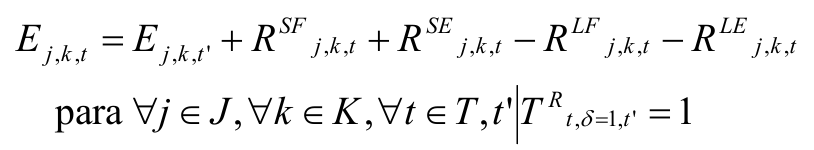

In [52]:
# Restrição de balanço de contêineres vazios nos portos
count_constr = 0
for j in dados.P:
    for k in dados.K:
        for t in dados.T:
            count_constr += 1
            model.addConstr(
                        E[j, k, t] == E[j, k, dados.T[-1] if t == 1 else t - 1] + RSE[j, k, t] + RSF[j, k, t] - RLE[j, k, t] - RLF[j, k, t],
                        name=f"balanco_conteineres_vazios_{j}_{k}_{t}"
                    )
print(f"Restrições de balanço de contêineres vazios nos portos: {count_constr}")


Restrições de balanço de contêineres vazios nos portos: 480


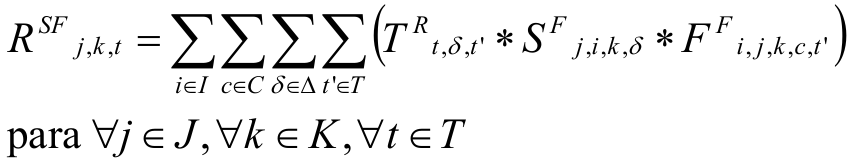

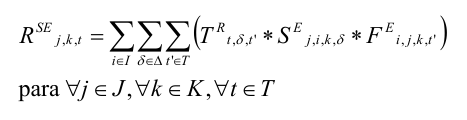

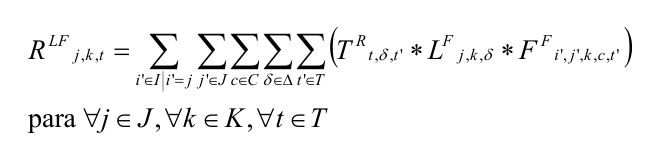

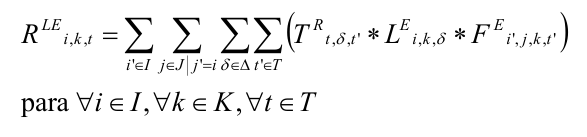

Problema: Dados.SF só tem dados para 5 portos, enquanto os outros dados chegam aos 10 portos.

Solução? Assumir que os dados para os outros portos são iguais.

In [53]:
# Restrição de quantidade de contêineres vazios devolvida de importação
count_constr = 0
for j in dados.P:
    for k in dados.K:
        for t in dados.T:
                model.addConstr(
                    RSF[j, k, t] == quicksum([dados.TR[t, delta, t_] * FF[i, j, k, c, t_] * dados.SF[(dados.SF['I'] == ordem.loc[j].values[0]) & (dados.SF['K'] == k) & (dados.SF['DT'] == delta)]['SF'].values[0] for i in dados.P for c in dados.C for delta in dados.DT for t_ in dados.T]),
                    name=f"quantidade_conteineres_vazios_devolvida_{j}_{k}_{t}"
                )
                model.addConstr(
                    RSE[j, k, t] == quicksum([dados.TR[t, delta, t_] * FE[i, j, k, t_] * dados.SE[(dados.SE['K'] == k) & (dados.SE['DT'] == delta)]['SE'].values[0] for i in dados.P for delta in dados.DT for t_ in dados.T]),
                    name=f"quantidade_conteineres_disponiveis_pos_reposicionamento_{j}_{k}_{t}"
                )
                model.addConstr(
                RLF[j, k, t] == quicksum(
                    dados.TR[t, delta, t_] * dados.LF[(j, k, delta)] * FF[i_, j_, k, c, t_]
                    for i_ in dados.P if i_ == j
                    for j_ in dados.P
                    for c in dados.C
                    for delta in dados.DT
                    for t_ in dados.T
                ),
                name=f"restricao_RLF_{j}_{k}_{t}"
                )
                model.addConstr(
                RLE[i, k, t] == quicksum(
                    dados.TR[t, delta, t_] * dados.LF[(i, k, delta)] * FE[i_, j_, k, t_]
                    for i_ in dados.P if i_ == j
                    for j_ in dados.P
                    for c in dados.C
                    for delta in dados.DT
                    for t_ in dados.T
                ),
                name=f"restricao_RLE_{i}_{k}_{t}"
                )
                count_constr += 1
print(f"Restrições de quantidade máxima de contêineres armazenada em cada porto: {count_constr}")

Restrições de quantidade máxima de contêineres armazenada em cada porto: 480


Sf e Se considera apenas porto de chegada (índice I do Excel representa J)

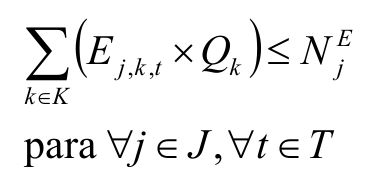

In [81]:
# Restrição de quantidade máxima de contêineres vazios em cada porto
count_constr = 0
for j in dados.P:
    for t in dados.T:
        model.addConstr(
            quicksum(E[(j, k, t)] * dados.Q[(dados.Q['K'] == k)]['Q'].values[0] for k in dados.K) <= dados.NE[(dados.NE['I'] == ordem.loc[j].values[0])]['NE'].values[0],
            name=f"restricao_quantidade_maxima_conteineres_{j}_{t}"
        )
        count_constr += 1

print(f"Restrições de quantidade máxima de contêineres vazios em cada porto: {count_constr}")

Restrições de quantidade máxima de contêineres vazios em cada porto: 120


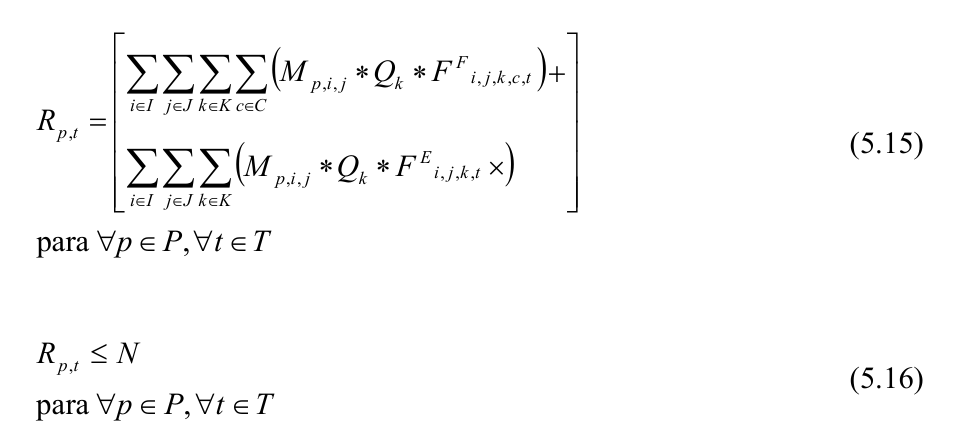

In [91]:
# Restrição (5.15) para calcular Rp,t
count_constr = 0
for p in dados.P:
    for t in dados.T:
        model.addConstr(
            R[p, t] == quicksum(
                dados.M[(dados.M['P'] == p) & (dados.M['I'] == ordem.loc[i].values[0]) & (dados.M['J'] == ordem.loc[j].values[0])]['M'].values[0]
                * dados.Q[(dados.Q['K'] == k)]['Q'].values[0] 
                * FF[i, j, k, c, t]
                for i in dados.P
                for j in dados.P
                for k in dados.K
                for c in dados.C
            ) + quicksum(
                dados.M[(dados.M['P'] == p) & (dados.M['I'] == ordem.loc[i].values[0]) & (dados.M['J'] == ordem.loc[j].values[0])]['M'].values[0]
                * dados.Q[(dados.Q['K'] == k)]['Q'].values[0] 
                * FE[i, j, k, t]
                for i in dados.P
                for j in dados.P
                for k in dados.K
            ),
            name=f"calculo_R_{p}_{t}"
        )
        count_constr += 1

# Restrição (5.16) para limitar Rp,t a N
for p in dados.P:
    for t in dados.T:
        model.addConstr(
            R[p, t] <= dados.N,
            name=f"limite_R_{p}_{t}"
        )
        count_constr += 1

print(f"Restrições adicionadas: {count_constr}")


Restrições adicionadas: 240


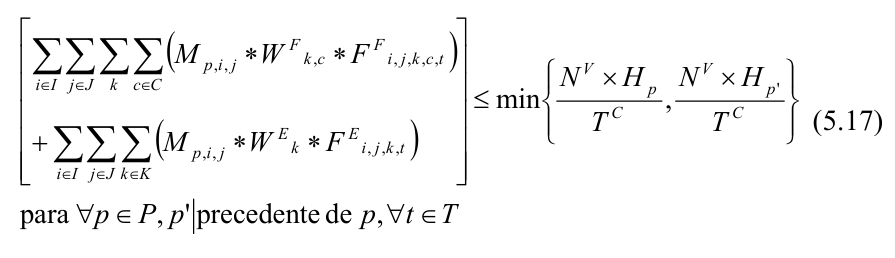

In [97]:
dados.WE

,K,WE
0,1,2
1,2,2
2,3,4
3,4,4


In [100]:
# Restrição de calado máximo nos portos
count_constr = 0
index = -1
for p in dados.P:
    p_ = dados.P[index - 1]
    index += 1
    h = dados.H[dados.H['P'] == p]['H'].values[0]
    h_ = dados.H[dados.H['P'] == p_]['H'].values[0]
    h_value = min(h, h_)
    for t in dados.T:
        count_constr += 1
        model.addConstr(
            quicksum(
                dados.M[(dados.M['P'] == p) & (dados.M['I'] == ordem.loc[i].values[0]) & (dados.M['J'] == ordem.loc[j].values[0])]['M'].values[0]
                * dados.WF[(dados.WF['K'] == k) & (dados.WF['C'] == c)]['WF'].values[0] 
                * FE[i, j, k, t]
                for i in dados.P
                for j in dados.P
                for k in dados.K
                for c in dados.C
            )
            +
            quicksum(
                dados.M[(dados.M['P'] == p) & (dados.M['I'] == ordem.loc[i].values[0]) & (dados.M['J'] == ordem.loc[j].values[0])]['M'].values[0]
                * dados.WE[(dados.WE['K'] == k)]['WE'].values[0] 
                * FE[i, j, k, t]
                for i in dados.P
                for j in dados.P
                for k in dados.K
            )
            <=
            h_value * dados.NV / dados.TC,
            name=f"calado_maximo_porto_{p}_{t}"
            )
print(f"Restrições de calado máximo nos portos: {count_constr}")

Restrições de calado máximo nos portos: 120


In [57]:
# Restrição de quantidade de contêineres frigoríficos cheios nos navios
count_constr = 0
for p in dados.P:
    for t in dados.T:
        count_constr += 1
        model.addConstr(
            quicksum(FF[i, j, k, c, t] for i in dados.P for j in dados.P for k in dados.K for c in dados.C if dados.G.iloc[k-1, 1] == 1) <= dados.NP,
            name=f"capacidade_maxima_refrigerados_{p}_{t}"
        )
print(f"Restrições de quantidade de contêineres frigoríficos cheios nos navios: {count_constr}")


Restrições de quantidade de contêineres frigoríficos cheios nos navios: 120


In [58]:
# Restrição de quantidade de contêineres de 40 pés nos navios
count_constr = 0
for p in dados.P:
    for t in dados.T:
        if not dados.M.empty:
            count_constr += 1
            model.addConstr(
                quicksum(dados.M.iloc[p-1, k-1] * FF[i, j, k, c, t] for i in dados.P for j in dados.P for k in dados.K for c in dados.C) +
                quicksum(dados.M.iloc[p-1, k-1] * FE[i, j, k, t] for i in dados.P for j in dados.P for k in dados.K) <= 
                (dados.NV * dados.NF) / (len(dados.T) * len(dados.C)),
                name=f"quantidade_maxima_conteineres_40_pes_{p}_{t}"
            )
print(f"Restrições de quantidade de contêineres de 40 pés nos navios: {count_constr}")


Restrições de quantidade de contêineres de 40 pés nos navios: 120


In [106]:
for k in dados.K:
    for t in dados.T:
        part1 = quicksum(FF[i, j, k, c, t] for i in dados.P for j in dados.P for c in dados.C)
        part2 = quicksum(FE[i, j, k, t] for i in dados.P for j in dados.P)
        part3 = quicksum(E[j, k, t] for j in dados.P)
        
        part4 = quicksum(
            dados.TR[t, delta, t_] * FF[i, j, k, c, t_] * dados.SF[(dados.SF['I'] == ordem.loc[j].values[0]) & (dados.SF['K'] == k) & (dados.SF['DT'] == delta)]['SF'].values[0] +
            dados.TR[t, delta, t_] * FE[i, j, k, t_] * dados.SE[(dados.SE['K'] == k) & (dados.SE['DT'] == delta)]['SE'].values[0]
            for i in dados.P 
            for j in dados.P 
            for c in dados.C 
            for delta in dados.DT 
            for t_ in dados.T
            if delta > 1 and dados.TR[t, delta, t_] == 1
        )

        part5 = quicksum(
            dados.TR[t, delta, t_] * dados.LF[j1, k, delta] * FF[i, j, k, c, t_] +
            dados.TR[t, delta, t_] * dados.LE[j1, k, delta] * FE[i, j, k, t_]
            for i in dados.P
            for j in dados.P 
            for j1 in dados.P 
            for c in dados.C 
            for delta in dados.DT 
            for t_ in dados.T
            if delta > 1 and dados.TR[t, delta, t_] == 1 and j1 == i
        )
        
        total_sum = part1 + part2 + part3 + part4 + part5
        
        model.addConstr(total_sum <= dados.NC[dados.NC['K'] == k]['NC'].values[0], name=f"lim_frota_{k}_{t}")